### Basic Chatbot with langgraph(Graph API)

#### Components of langgraph
- Edge
- Node
- state (this part will store the variables that will be utilised in some of the edges and nodes)

Yt videos --> Blog

- workflow
1. Yt vides --> Transcript
2. Transcript --> title
3. Title,Transcript --> Content


workflow graph:

            start(input as YT url)
              |
              |  - Edge (genreating transcript from Youtube URl using langchains YTloader)
         
         Transcript generator (node)
           
              |
              |  - transcript as variable traversing through edge
        
        Title Generator (Generates title based on Transcript Provided)
           
              |
              | - Transript and title traversing through this edge
        
        Content Generator (Generates content based on Transcript and Title Provided)

above diagram is StateGraph

In [1]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages

In [2]:
class state(TypedDict):
    #messages have the format of a list of strings. the 'add_messages' function will
    #automatically add the messages to the state. in the annotation,defines how the 
    # messages are stored in the state.
    messages: Annotated[list[str], add_messages]
    # in this case, it appends the messages to the list, rather than replacing it.
    # the 'messages' key is a list of strings, which will be used to store the messages.
graph_builder = StateGraph(state)

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [4]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

In [5]:
llm = ChatGroq(model = "llama3-8b-8192" )

In [6]:
# Node function to handle the START state
def chatbot(state: state) -> str:
    # this function will be called when the graph reaches the END state
    # it will return the messages stored in the state as a single string
    return {"messages":[llm.invoke(state["messages"])]}

In [7]:
graph_builder

In [8]:
# Add the START node to the graph
graph_builder.add_node(
    "llmchatbot",
    chatbot)
# add the edge from START to the llmchatbot node
# and from the llmchatbot node to the END state
graph_builder.add_edge(START, "llmchatbot")
graph_builder.add_edge("llmchatbot", END)
# Create the graph or compile the graph
graph = graph_builder.compile()

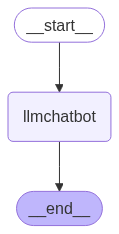

In [9]:
#Visualize the graph
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [10]:
response = graph.invoke({"messages": ["Hello, how are you?"]})

In [11]:
response['messages'][-1]  # Get the last message from the response
# This will return the response from the LLM based on the input message

AIMessage(content="I'm just a language model, I don't have emotions or feelings like humans do, but I'm functioning properly and ready to assist you with any questions or tasks you may have! It's great to chat with you. Is there something specific you'd like to talk about or ask?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 59, 'prompt_tokens': 16, 'total_tokens': 75, 'completion_time': 0.120223102, 'prompt_time': 0.008017593, 'queue_time': 0.379037988, 'total_time': 0.128240695}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--15f3db40-c19c-43f9-87e1-b256076f6e8f-0', usage_metadata={'input_tokens': 16, 'output_tokens': 59, 'total_tokens': 75})

In [12]:
response['messages'][-1].content  # Get the content of the last message
# This will return the text content of the response from the LLM

"I'm just a language model, I don't have emotions or feelings like humans do, but I'm functioning properly and ready to assist you with any questions or tasks you may have! It's great to chat with you. Is there something specific you'd like to talk about or ask?"

In [13]:
response['messages']  # Get the role of the last message

[HumanMessage(content='Hello, how are you?', additional_kwargs={}, response_metadata={}, id='d3a141b7-0140-4977-9718-2b09fb55297c'),
 AIMessage(content="I'm just a language model, I don't have emotions or feelings like humans do, but I'm functioning properly and ready to assist you with any questions or tasks you may have! It's great to chat with you. Is there something specific you'd like to talk about or ask?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 59, 'prompt_tokens': 16, 'total_tokens': 75, 'completion_time': 0.120223102, 'prompt_time': 0.008017593, 'queue_time': 0.379037988, 'total_time': 0.128240695}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--15f3db40-c19c-43f9-87e1-b256076f6e8f-0', usage_metadata={'input_tokens': 16, 'output_tokens': 59, 'total_tokens': 75})]

In [14]:
for event in graph.stream({"messages":'Hi, How are you?'}):
    for value in event.values():
        print(value['messages'][-1].content)
# This will print the content of the last message in each event as the stream progresses

Hi! I'm just a language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help with any questions or tasks you have! How can I assist you today?


### Chatbot with Tool

___Start___
     |
     |
tool_calling_llm (Node) (LLM with binding tools)
     |
     |
|            |
|            |
|        Tools (tavily API (internet search))
|               (Custom tools)
|            |
  ___END___

In [15]:
from langchain_tavily import TavilySearch

In [16]:
tool = TavilySearch(max_results=2)
# tool.invoke("What is the capital of France?")

In [17]:
#custom function
def MultiplyXbyY(x: int,y:int) -> int:
    """_summary_

    Args:
        x (int): _description_

    Returns:
        int: _description_
    """
    return x * y

In [18]:
tools = [tool, MultiplyXbyY] 
# List of tools to be used in the graph

In [19]:
llm_with_tools = llm.bind_tools(tools)
# Bind the tools to the LLM
# This will allow the LLM to use the tools in its responses

In [20]:
## stategraph with tools
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

In [21]:
##Node definition
def tool_calling_llm(state: state) -> str:
    """_summary_

    Args:
        state (state): _description_

    Returns:
        str: _description_
    """
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


builder = StateGraph(state)
builder.add_node(
    "tool_calling_llm",
    tool_calling_llm 
)
builder.add_node(
    "tools",
    ToolNode(tools)
)

#add the edges to the graph
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
# if the tool calling LLM returns a tool call, it will go to the tools node
# if the LLM does not return a tool call, it will go to the END state
builder.add_edge("tools", END)

In [22]:
#compile the graph
graph = builder.compile()

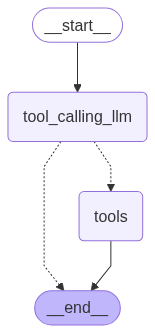

In [23]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [24]:
response = graph.invoke({"messages": ["What is the recent AI News?"]})

In [25]:
response

{'messages': [HumanMessage(content='What is the recent AI News?', additional_kwargs={}, response_metadata={}, id='44249154-ae84-43da-b30a-48852853f32e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'wzm902m9h', 'function': {'arguments': '{"query":"recent AI news","search_depth":"advanced","time_range":"week"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 86, 'prompt_tokens': 2188, 'total_tokens': 2274, 'completion_time': 0.143292542, 'prompt_time': 0.254151126, 'queue_time': 0.273942492, 'total_time': 0.397443668}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_2717d04279', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e95611fa-77b0-4b73-925f-d0b80e77b46b-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'recent AI news', 'search_depth': 'advanced', 'time_range': 'week'}, 'id': 'wzm902m9h', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2188, 'output_tokens': 86, 

In [26]:
response['messages'][-1].content
# Get the content of the last message in the response

'{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "AI News | Latest Headlines and Developments | Reuters", "url": "https://www.reuters.com/technology/artificial-intelligence/", "content": "This was originally published in the Artificial Intelligencer newsletter, which is issued every Wednesday. Sign up here to learn about the latest breakthroughs in AI and tech.", "score": 0.98589, "raw_content": null}, {"title": "Top AI Breakthroughs of June 2025: Transforming Technology for the ...", "url": "https://nriglobe.com/tech-news/top-ai-breakthroughs-of-june-2025-transforming-technology-for-the-global-community/", "content": "Top AI Breakthroughs of June 2025: Transforming Technology for the Global Community June 2025 has been a landmark week for artificial intelligence, with innovations that promise to reshape industries, empower creators, and advance scientific discovery. From Google\'s developer tools to groundbreaking genomic mo

In [27]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

What is the recent AI News?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (wzm902m9h)
 Call ID: wzm902m9h
  Args:
    query: recent AI news
    search_depth: advanced
    time_range: week
================================= Tool Message =================================
Name: tavily_search

{"query": "recent AI news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "AI News | Latest Headlines and Developments | Reuters", "url": "https://www.reuters.com/technology/artificial-intelligence/", "content": "This was originally published in the Artificial Intelligencer newsletter, which is issued every Wednesday. Sign up here to learn about the latest breakthroughs in AI and tech.", "score": 0.98589, "raw_content": null}, {"title": "Top AI Breakthroughs of June 2025: Transforming Technology for the ...", "url": "https:/

In [28]:
response = graph.invoke({"messages": ["What is the 10 multiply by 2?"]})

In [29]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

What is the 10 multiply by 2?
================================== Ai Message ==================================
Tool Calls:
  MultiplyXbyY (3xw8swk80)
 Call ID: 3xw8swk80
  Args:
    x: 10
    y: 2
================================= Tool Message =================================
Name: MultiplyXbyY

20


In [34]:
response = graph.invoke({"messages": ["What is the recent news about AI and then tell me what is 10 multiply by 5 ?"]})

In [35]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

What is the recent news about AI and then tell me what is 10 multiply by 5 ?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (hbbwvz26s)
 Call ID: hbbwvz26s
  Args:
    query: recent news about AI
    search_depth: advanced
    time_range: day
    topic: news
  MultiplyXbyY (t2e1qwr5t)
 Call ID: t2e1qwr5t
  Args:
    x: 10
    y: 5
================================= Tool Message =================================
Name: tavily_search

{"query": "recent news about AI", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://opentools.ai/news/metas-ai-talent-grab-openai-researchers-jump-ship-for-superintelligence-ambitions", "title": "Meta's AI Talent Grab: OpenAI Researchers Jump Ship for Superintelligence Ambitions - OpenTools", "score": 0.7905832529067993, "published_date": "Sun, 29 Jun 2025 11:36:00 GMT", "content"

In [36]:
response = graph.invoke({"messages": ["What is the capital of France?"]})

In [37]:
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

What is the capital of France?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (8e98xarf1)
 Call ID: 8e98xarf1
  Args:
    query: What is the capital of France?
================================= Tool Message =================================
Name: tavily_search

{"query": "What is the capital of France?", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "What is the Capital of France? - WorldAtlas", "url": "https://www.worldatlas.com/articles/what-is-the-capital-of-france.html", "content": "Paris is the capital city of France. Contrary to popular belief, the name of the city did not come from the Paris in Greek myths. Located in the north of Central France, the city is relatively flat with the highest point being 427 feet (which is Montmartre) above sea level while the lowest point is 115 feet above the sea level.

## ReACT Agent Architecture

1. Action - whenever input comes to LLM, LLM will make a tool call
2. Observe - When output comes from Tool Node, LLM observe, whether it should make tool call or go to the end node
3. Reason - The LLM analyzes the current task, the history of previous actions and observations, and the overall goal.This is analogous to a human thinking through a problem before acting.

In [ ]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

In [ ]:
builder = StateGraph(state)
builder.add_node(
    "tool_calling_llm",
    tool_calling_llm 
)
builder.add_node(
    "tools",
    ToolNode(tools)
)
# add the edges to the graph
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
# if the tool calling LLM returns a tool call, it will go to the tools node
builder.add_edge("tools", "tool_calling_llm")
#LLM will call the tools node again if it returns a tool call
graph = builder.compile()

In [ ]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
response = graph.invoke({"messages": ["What is the recent AI News and then what is 10 multiply by 5 ?"]})
for message in response['messages']:
    message.pretty_print()